(1080, 1920, 3)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


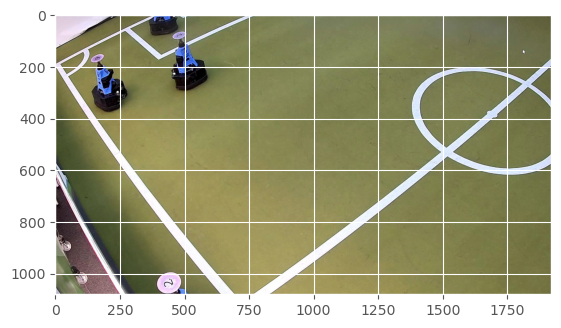

In [37]:
import cv2
import numpy as np
import skimage
from skimage.exposure import equalize_hist
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt
from glob import glob
from scipy.spatial.distance import cdist
import IPython.display as ipd
from tqdm import tqdm

import subprocess

plt.style.use('ggplot')
img = cv2.imread('TopView.png')
display(img.shape)
plt.imshow(img, cmap='gray')


pts = np.array([[864, 651], [1016, 581], [1205, 667], [1058, 759]], dtype=np.float32)
for pt in pts:
    cv2.circle(img, tuple(pt.astype(np.int)), 1, (0,0,255), -1)

# Helper Functions 

In [38]:
def get_image_boxes(outputs, image_width, image_height, classes, confidence_threshold=0.4, nms_threshold=0.3):
    class_ids = []
    confidences = []
    boxes = []

    for output in outputs:
        for detection in output:
            scores = detection[5]
            class_id = np.argmax(scores)
            class_name = classes[class_id]
            confidence = scores[class_id]
            if confidence > confidence_threshold and class_name== 'Robot1':
                cx, cy, width, height = (detection[0:4] * np.array([image_width, image_height, image_width, image_height])).astype("int")
                x = int(cx - width / 2)
                y = int(cy - height / 2)
                boxes.append([x, y, int(width), int(height),cx,cy])
                confidences.append(float(confidence))
    nms_indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)
    
    return [boxes[ind] for ind in nms_indices.flatten()]
def compute_point_perspective_transformation(matrix,boxes):
    list_downoids = [[box[4], box[5]+box[3]//2] for box in boxes]
    list_points_to_detect = np.float32(list_downoids).reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(list_points_to_detect, matrix)
    transformed_points_list = list()
    for i in range(0,transformed_points.shape[0]):
        transformed_points_list.append([transformed_points[i][0][0],transformed_points[i][0][1]])
    return np.array(transformed_points_list).astype('int')



def eucledian_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return sqrt((x1-x2)**2 + (y1-y2)**2)

def get_birds_eye_view_image(green_box, red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('black_background.png')
    
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    
    for point in green_box:
        cv2.circle(blank_image,tuple([point[6],point[7]]),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple([point[6],point[7]]),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    return blank_image


def get_box_image(new_box_image,box):
    for point in box:
        cv2.rectangle(new_box_image,(point[0],point[1]),(point[0]+point[2],point[1]+point[3]),(0, 255, 0), 2)
    return new_box_image
def get_boxes(birds_eye_points,boxes):
    boxes = []
    new_boxes = [tuple(box) + tuple(result) for box, result in zip(boxes, birds_eye_points)]
    for i in range(0, len(new_boxes)-1):
            for j in range(i+1, len(new_boxes)):
                cxi,cyi = new_boxes[i][6:]
                cxj,cyj = new_boxes[j][6:]
                boxes.append(new_boxes[i])
                boxes.append(new_boxes[j])

    boxes = list(set(new_boxes))
    return (boxes)

def transform_position(pos,H_matrix):
    list_points_to_detect = np.float32(pos).reshape(-1, 1, 2)
    transformed_points = cv2.perspectiveTransform(list_points_to_detect, H_matrix)
    return np.asarray(transformed_points).reshape(-1)

def eucledian_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return sqrt((x1-x2)**2 + (y1-y2)**2)

# Points Choose to transform

In [39]:
import numpy as np
import cv2 as cv

drawing = False # true if mouse is pressed
src_x, src_y = -1,-1

src_list = []

def select_points_src(event,x,y,flags,param):
    global src_x, src_y, drawing
    if event == cv.EVENT_LBUTTONDOWN:
        drawing = True
        src_x, src_y = x,y
        cv.circle(src_copy,(x,y),5,(0,0,255),-1)
    elif event == cv.EVENT_LBUTTONUP:
        drawing = False

src_path = 'test1.jpg'

src = cv.imread(src_path, -1)
src_copy = src.copy()
cv.namedWindow('src', cv.WINDOW_NORMAL)
cv.setMouseCallback('src', select_points_src)

while(1):
    cv.imshow('src',src_copy)
    k = cv.waitKey(1) & 0xFF
    if k == ord('s'):
        print('save points')
        cv.circle(src_copy,(src_x,src_y),5,(0,255,0),-1)
        src_list.append([src_x,src_y])
        print("src points:")
        print(src_list)      
    elif k == 27:
        break
cv.destroyAllWindows()

In [40]:
import cv2
import numpy as np
original_image_BGR = cv2.imread('test1.jpg')
original_image_RGB = cv2.cvtColor(original_image_BGR, cv2.COLOR_BGR2RGB)
image_width = original_image_RGB.shape[1]
image_height = original_image_RGB.shape[0]

original_image_BGR_copy = original_image_BGR.copy()
original_image_RGB_copy = original_image_RGB.copy()
# Define the ROI and corresponding points for IPM
ipm_pts = np.array([[0, 0],  [150,155], [660, 155], [405, 605]], dtype=np.float32)
roi = np.array([[349, 133], [386, 236], [1220, 124], [282, 914]], dtype=np.float32)
img = cv2.imread('test1.jpg')
# Compute the IPM matrix
H_matrix = cv2.getPerspectiveTransform(roi, ipm_pts)
dst_size=(1080, 1920)
# Apply the IPM matrix to the input image
ipm = cv2.warpPerspective(img, H_matrix,dst_size)

# Display the input image and the IPM result
cv2.imshow('Input Image', img)
cv2.imshow('IPM Result', ipm)
cv2.waitKey(0)
cv2.destroyAllWindows()

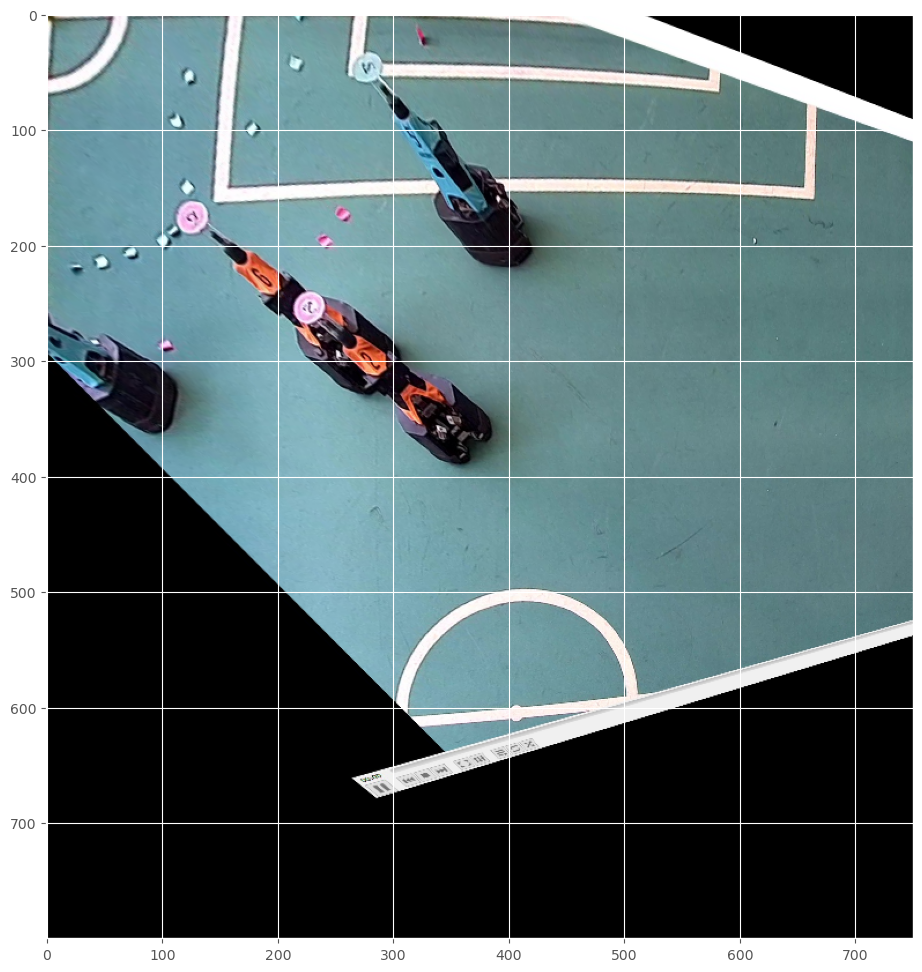

1920
[[ 3.29601991e+00  2.79448561e+00 -1.52197754e+03]
 [ 8.06769259e-01  3.82129887e+00 -7.89795222e+02]
 [ 2.36108178e-03  3.47678304e-03  1.00000000e+00]]


In [41]:

warped = cv2.warpPerspective(original_image_RGB_copy, H_matrix, (750,800))

plt.figure(figsize=(12, 12))
plt.imshow(warped)
plt.show()
print(image_width)
print(H_matrix)

# Model Predictions

In [42]:
from roboflow import Roboflow
rf = Roboflow(api_key="0HPgx6Yl0BWMjeGp9Wsc")
project = rf.workspace().project("autoref")
model = project.version(1).model
print(model.predict("test1.jpg", confidence=50, overlap=50).json())
# model.predict("your_image.jpg", confidence=40, overlap=30).save("prediction.jpg")
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())
#output=model.predict("test1.jpg", confidence=50, overlap=50)
#print(output)
# visualize your prediction
#model.predict("test1.jpg", confidence=50, overlap=50).save("Prediction.jpg")

# infer on an image hosted elsewhere
# print(model.predict("URL_OF_YOUR_IMAGE", hosted=True, confidence=40, overlap=30).json())

loading Roboflow workspace...
loading Roboflow project...
{'predictions': [{'x': 649.5, 'y': 179.5, 'width': 121.0, 'height': 229.0, 'confidence': 0.918950080871582, 'class': 'Team_Blue', 'image_path': 'test1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 391.5, 'y': 317.5, 'width': 125.0, 'height': 239.0, 'confidence': 0.9017873406410217, 'class': 'Team_Red', 'image_path': 'test1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 181.5, 'y': 379.0, 'width': 85.0, 'height': 180.0, 'confidence': 0.9002597332000732, 'class': 'Team_Blue', 'image_path': 'test1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 454.0, 'y': 396.5, 'width': 142.0, 'height': 243.0, 'confidence': 0.8917139768600464, 'class': 'Team_Red', 'image_path': 'test1.jpg', 'prediction_type': 'ObjectDetectionModel'}, {'x': 346.0, 'y': 120.0, 'width': 28.0, 'height': 46.0, 'confidence': 0.8577961325645447, 'class': 'Ball', 'image_path': 'test1.jpg', 'prediction_type': 'ObjectDetectionModel'}], 'image': {

In [45]:

# Open the video file for reading

cap = cv2.VideoCapture("2v2.mp4")
n_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# Get the video frame rate and dimensions
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object for writing the output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

for frame in range(n_frames):
    # read the current frame
    ret, img =cap.read()
    if ret == False:
        break

    # predict on the current frame using the model
    response = model.predict(img, confidence=70 , overlap=30)
    # Draw predicted boxes on the frame
    for obj in response.json()["predictions"]:
        x1 = obj["x"]-(obj["width"]/2)
        y1 = obj["y"]-(obj["height"]/2)
        x2 = obj["x"]+(obj["width"]/2)
        y2 = obj["y"]+(obj["height"]/2)
        label = obj["class"]
        confidence = obj["confidence"]
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, f"{label}: {confidence:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Write the frame to the output video
    out.write(img)

    # Display the frame (optional)
    cv2.imshow("frame", img)
    if cv2.waitKey(1) == ord("q"):
        break

# Release video capture and video writer
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()

In [48]:
xrobotr=[];yrobotr=[];heightr=[];widthr=[];confidencer=[];
xrobotb=[];yrobotb=[];heightb=[];widthb=[];confidenceb=[];
red_pos=[]
blue_pos=[]
# Open the video file for reading
red_pose=[];blue_pos=[];
cap = cv2.VideoCapture("2v2.mp4")
n_frames=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# Get the video frame rate and dimensions
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a VideoWriter object for writing the output video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (width, height))

for frame in range(n_frames):
    red_pos=[]
    blue_pos=[]
    # read the current frame
    ret, img =cap.read()
    if ret == False:
        break

    # predict on the current frame using the model
    response = model.predict(img, confidence=60 , overlap=30)
    # Draw predicted boxes on the frame
    for obj in response.json()["predictions"]:
        width=obj["width"]
        height=obj["height"]
        label = obj["class"]
        confidence = obj["confidence"]
        xposition=obj["x"]
        yposition=obj["y"]
        x1 = xposition-width/2
        y1 = yposition-(height/2)
        x2 = xposition+(width/2)
        y2 = yposition+(height/2)
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(img, f"{label}: {confidence:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        if label == 'Ball':
            ball_pos=[xposition,yposition]
        if label =='Team_Blue':
            blue_pos.append([xposition,yposition])
        if label == 'Team_Red':
            red_pos.append([xposition,yposition]) 
    transformed_points_ball=transform_position(ball_pos,H_matrix)
    transformed_points_blue=transform_position(blue_pos,H_matrix)
    transformed_points_red=transform_position(red_pos,H_matrix)
    #blue_team=(eucledian_distance(transformed_points_blue[0:2],transformed_points_ball))
    #print(blue_team)
    # Write the frame to the output video
    out.write(img)

    # Display the frame (optional)
    cv2.imshow("frame", img)
    if cv2.waitKey(1) == ord("q"):
        break

# Release video capture and video writer
cap.release()
out.release()

# Close all windows
cv2.destroyAllWindows()

In [30]:
xrobotr=[];yrobotr=[];heightr=[];widthr=[];confidencer=[];
xrobotb=[];yrobotb=[];heightb=[];widthb=[];confidenceb=[];

for pred in response.json()['predictions']:
    if pred['class'] == 'Ball':
        xball = pred['x']
        yball = pred['y']
        heightball=pred['height']
        widthball=pred['width']
    if pred['class'] == 'Team_Red':
        xrobotr.append(pred['x'])
        yrobotr.append(pred['y'])
        heightr.append(pred['height'])
        widthr.append(pred['width'])
        confidencer.append(pred["confidence"])
    if pred['class'] == 'Team_Blue':
        xrobotb.append(pred['x'])
        yrobotb.append(pred['y'])
        heightb.append(pred['height'])
        widthb.append(pred['width'])
        confidenceb.append(pred["confidence"])

print(xrobotb)
print(yrobotb)
print(xball)
print(yball)
ball_pos=[xball,yball];
robot_pos1=[xrobotb[0],yrobotb[0]]
robot_pos2=[xrobotb[1],yrobotb[1]]
robot_pos3=[xrobotr[0],yrobotr[0]]
robot_pos4=[xrobotr[1],yrobotr[1]]
list_points_to_detect_ball = np.float32(ball_pos).reshape(-1, 1, 2)
transformed_points_ball = cv2.perspectiveTransform(list_points_to_detect_ball, H_matrix)
transformed_points_ball=np.asarray(transformed_points_ball).reshape(-1)
list_points_to_detect_b1 = np.float32(robot_pos1).reshape(-1, 1, 2)
transformed_points_b1 = cv2.perspectiveTransform(list_points_to_detect_b1, H_matrix)
transformed_points_b1=np.asarray(transformed_points_b1).reshape(-1)
list_points_to_detect_b2 = np.float32(robot_pos2).reshape(-1, 1, 2)
transformed_points_b2 = cv2.perspectiveTransform(list_points_to_detect_b2, H_matrix)
transformed_points_b2=np.asarray(transformed_points_b2).reshape(-1)

list_points_to_detect_r1 = np.float32(robot_pos3).reshape(-1, 1, 2)
transformed_points_r1 = cv2.perspectiveTransform(list_points_to_detect_r1, H_matrix)
transformed_points_r1=np.asarray(transformed_points_r1).reshape(-1)
list_points_to_detect_r2 = np.float32(robot_pos4).reshape(-1, 1, 2)
transformed_points_r2 = cv2.perspectiveTransform(list_points_to_detect_r2, H_matrix)
transformed_points_r2=np.asarray(transformed_points_r2).reshape(-1)
print(transformed_points_r2[0])


[179.5, 263.5]
[382.0, 262.5]
343.0
120.5
[307.97388 310.74484]


In [27]:
#boxes = get_image_boxes(output, image_width, image_height, classes)
blue_boxes=[];
red_boxes=[]
ball_boxes=[]
coonfidences=[];
cx, cy, width, height = ([xrobotr[0],yrobotr[0],heightr[0],widthr[0]] * np.array([image_width, image_height, image_width, image_height])).astype("int")
x = int(cx - width / 2)
y = int(cy - height / 2)
red_boxes.append([x, y, int(width), int(height),cx,cy])
cx, cy, width, height = ([xrobotr[1],yrobotr[1],heightr[1],widthr[1]] * np.array([image_width, image_height, image_width, image_height])).astype("int")
x = int(cx - width / 2)
y = int(cy - height / 2)
red_boxes.append([x, y, int(width), int(height),cx,cy])
cx, cy, width, height = ([xrobotb[0],yrobotb[0],heightb[0],widthb[0]] * np.array([image_width, image_height, image_width, image_height])).astype("int")
x = int(cx - width / 2)
y = int(cy - height / 2)
blue_boxes.append([x, y, int(width), int(height),cx,cy])
cx, cy, width, height = ([xrobotb[1],yrobotb[1],heightb[1],widthb[1]] * np.array([image_width, image_height, image_width, image_height])).astype("int")
x = int(cx - width / 2)
y = int(cy - height / 2)
blue_boxes.append([x, y, int(width), int(height),cx,cy])
cx, cy, width, height = ([xball,yball,heightball,widthball] * np.array([image_width, image_height, image_width, image_height])).astype("int")
x = int(cx - width / 2)
y = int(cy - height / 2)
ball_boxes.append([x, y, int(width), int(height),cx,cy])

print(ball_boxes)
print(blue_boxes[0])

[[620160, 106424, 88320, 28112, 664320, 120480]]
[1027200, 119476, 439680, 121484, 1247040, 180218]


In [25]:
birds_eye_points_red = compute_point_perspective_transformation(H_matrix, red_boxes)
birds_eye_points_ball = compute_point_perspective_transformation(H_matrix, ball_boxes)
birds_eye_points_blue = compute_point_perspective_transformation(H_matrix, blue_boxes)

print(birds_eye_points_blue[0])
print(birds_eye_points_blue[1])
print(birds_eye_points_ball[0])

[1264  509]
[1015  826]
[1258  515]


In [17]:
#birds_eye_view_image = get_birds_eye_view_image(red_boxes,blue_boxes,eye_view_height=image_height,eye_view_width=image_width//2)
#plt.figure()
#plt.imshow(cv2.cvtColor(birds_eye_view_image, cv2.COLOR_RGB2BGR))
#plt.show()

In [18]:
from math import sqrt
def eucledian_distance(point1, point2):
    x1,y1 = point1
    x2,y2 = point2
    return sqrt((x1-x2)**2 + (y1-y2)**2)

In [23]:
distancebetweenblue=eucledian_distance(birds_eye_points_blue[0],birds_eye_points_ball[0])
print(distancebetweenblue)

8.48528137423857


In [54]:
distancebetweenblue=eucledian_distance(transformed_points_b1,transformed_points_ball)
print(distancebetweenblue)

406.76835713886624


In [55]:
distancebetweenblue=eucledian_distance(transformed_points_b2,transformed_points_ball)
print(distancebetweenblue)

324.05793232824084


In [56]:
distancebetweenblue=eucledian_distance(transformed_points_r1,transformed_points_ball)
print(distancebetweenblue)

357.49063155429275


In [57]:
distancebetweenblue=eucledian_distance(transformed_points_r2,transformed_points_ball)
print(distancebetweenblue)

476.65992848240023


In [58]:
distancebetweenblue=eucledian_distance(transformed_points_r2,transformed_points_r1)
print(distancebetweenblue)

121.08852429008758


In [59]:
distancebetweenblue=eucledian_distance(transformed_points_b2,transformed_points_b1)
print(distancebetweenblue)

344.91402506576617


In [ ]:
i